In [1]:
import sys
sys.path.insert(1, '../python_modules')

In [2]:
#create config
from dataclasses import dataclass

@dataclass
class TrainingConfig:
    image_size = 256  # TODO: the generated image resolution
    channels = 1 
    train_batch_size = 4
    eval_batch_size = 4
    num_epochs = 73 #600
    gradient_accumulation_steps = 1
    learning_rate = 1e-4
    lr_warmup_steps = 100 #500
    evaluate_epochs = 1 #30
    evaluate_save_img_epochs = 20 #30
    evaluate_3D_epochs = 40 #30
    save_model_epochs = 60 # 300
    mixed_precision = "fp16"  # `no` for float32, `fp16` for automatic mixed precision
    output_dir = "lesion-filling-256-cond-lesions"  # the model name locally and on the HF Hub
    dataset_train_path = "./dataset_train/imgs"
    segm_train_path = "./dataset_train/segm"
    masks_train_path = "./dataset_train/masks"
    dataset_eval_path = "./dataset_eval/imgs"
    segm_eval_path = "./dataset_eval/segm"
    masks_eval_path = "./dataset_eval/masks"
    num_gpu=2
    train_only_connected_masks=True
    eval_only_connected_masks=False
    num_inference_steps=50
    debug=True
    #uniform_dataset_path = "./uniform_dataset"

    push_to_hub = False  # whether to upload the saved model to the HF Hub
    #hub_model_id = "<your-username>/<my-awesome-model>"  # the name of the repository to create on the HF Hub
    #hub_private_repo = False
    #overwrite_output_dir = True  # overwrite the old model when re-running the notebook
    seed = 0
config = TrainingConfig()

In [3]:
if config.debug:
    config.num_inference_steps=5
    config.train_batch_size = 1
    config.eval_batch_size = 1
    config.num_gpu=1
    config.train_only_connected_masks=False
    config.eval_only_connected_masks=False

In [4]:
#setup huggingface accelerate
import torch
import numpy as np
import accelerate
accelerate.commands.config.default.write_basic_config(config.mixed_precision)

Configuration already exists at /home/jovyan/.cache/huggingface/accelerate/default_config.yaml, will not override. Run `accelerate config` manually or pass a different `save_location`.


False

In [5]:
from Dim2DatasetMRI import Dim2DatasetMRI
from Dim3DatasetMRI import Dim3DatasetMRI
from pathlib import Path

#create dataset
datasetTrain = Dim2DatasetMRI(Path(config.dataset_train_path), Path(config.segm_train_path), Path(config.masks_train_path), pad_shape=(256, 256, 256), only_connected_masks=config.train_only_connected_masks)
datasetEvaluation = Dim2DatasetMRI(Path(config.dataset_eval_path), Path(config.segm_eval_path), Path(config.masks_eval_path), pad_shape=(256, 256, 256), only_connected_masks=config.eval_only_connected_masks)
dataset3DEvaluation = Dim3DatasetMRI(Path(config.dataset_eval_path), Path(config.segm_eval_path), Path(config.masks_eval_path), pad_shape=(256, 256, 256), only_connected_masks=config.eval_only_connected_masks)

print(f"Dataset size: {len(datasetTrain)}")
print(f"\tImage shape: {datasetTrain[0]['gt_image'].shape}")
print(f"Training Data: {list(datasetTrain[0].keys())}") 

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Dataset size: 2047
	Image shape: torch.Size([1, 256, 256])
Training Data: ['gt_image', 'segm', 'mask', 'max_v', 'idx']


### Visualize dataset

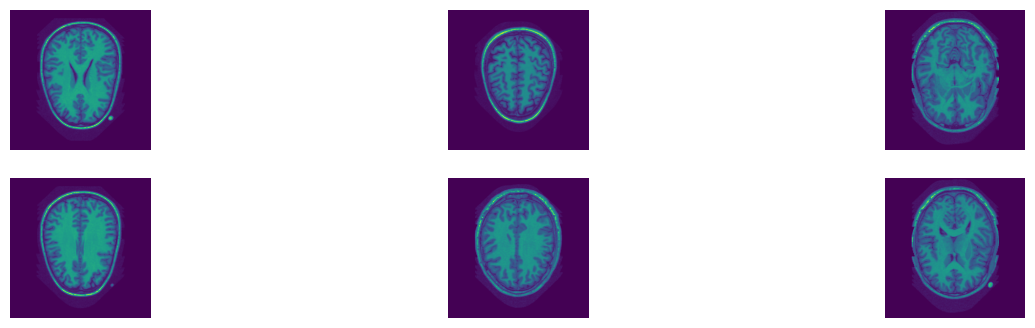

In [6]:
import matplotlib.pyplot as plt

# Get 6 random sample
random_indices = np.random.randint(0, len(datasetTrain) - 1, size=(6)) 

# Plot: t1n images
fig, axis = plt.subplots(2,3,figsize=(16,4))
for i, idx in enumerate(random_indices):
    axis[i//3,i%3].imshow((datasetTrain[idx]["gt_image"].squeeze()+1)/2)
    axis[i//3,i%3].set_axis_off()
fig.show()

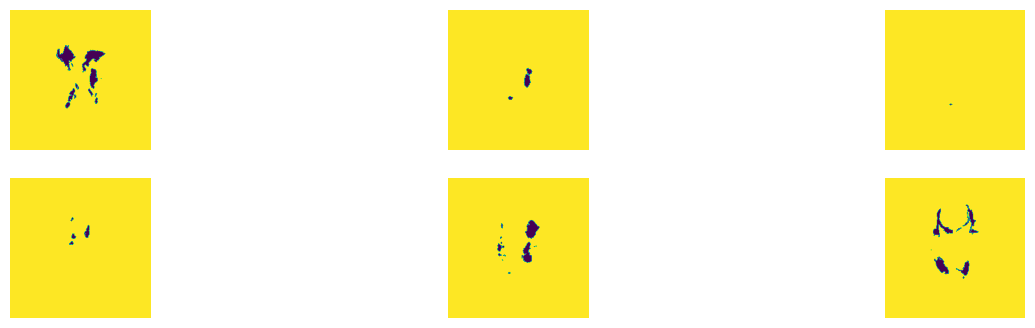

In [7]:
# Plot: masks
fig, axis = plt.subplots(2,3,figsize=(16,4))
for i, idx in enumerate(random_indices):
    axis[i//3,i%3].imshow(datasetTrain[idx]["mask"].squeeze())
    axis[i//3,i%3].set_axis_off()
fig.show()

### Prepare Training

In [8]:
from torch.utils.data import DataLoader

# create dataloader function, which is executed inside the training loop (necessary because of huggingface accelerate)
def get_dataloader(dataset, batch_size, shuffle, num_workers=4):
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)

In [9]:
#create model
from diffusers import UNet2DModel

model = UNet2DModel(
    sample_size=config.image_size,  # the target image resolution
    in_channels=3, # the number of input channels: 1 for img, 1 for img_voided, 1 for mask
    out_channels=config.channels,  # the number of output channels
    layers_per_block=2,  # how many ResNet layers to use per UNet block
    block_out_channels=(128, 128, 256, 256, 512, 512),  # the number of output channels for each UNet block
    down_block_types=(
        "DownBlock2D",  # a regular ResNet downsampling block
        "DownBlock2D",
        "DownBlock2D",
        "DownBlock2D",
        "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
        "DownBlock2D",
    ),
    up_block_types=(
        "UpBlock2D",  # a regular ResNet upsampling block
        "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
    ),
)

#tb_summary.add_text("model", "UNet2DModel", 0) 

In [10]:
#setup noise scheduler
import torch
from PIL import Image
from diffusers import DDIMScheduler

noise_scheduler = DDIMScheduler(num_train_timesteps=1000)
sample_image = datasetTrain[0]['gt_image'].unsqueeze(0)
noise = torch.randn(sample_image.shape)
timesteps = torch.LongTensor([50])
noisy_image = noise_scheduler.add_noise(sample_image, noise, timesteps)


#tb_summary.add_text("noise_scheduler", "DDIMScheduler(num_train_timesteps=1000)", 0) 




In [11]:
# setup lr scheduler
from diffusers.optimization import get_cosine_schedule_with_warmup
import math

optimizer = torch.optim.AdamW(model.parameters(), lr=config.learning_rate)
lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=config.lr_warmup_steps,
    num_training_steps=(math.ceil(len(datasetTrain)/config.train_batch_size) * config.num_epochs), # num_iterations per epoch * num_epochs
)

#tb_summary.add_text("lr_scheduler", "cosine_schedule_with_warmup", 0) 


In [12]:
from typing import List, Optional, Tuple, Union

from diffusers import DiffusionPipeline, DDIMScheduler, ImagePipelineOutput
from diffusers.utils.torch_utils import randn_tensor



class DDIMInpaintPipeline(DiffusionPipeline):
    r"""
    Pipeline for image inpainting.

    This model inherits from [`DiffusionPipeline`]. Check the superclass documentation for the generic methods
    implemented for all pipelines (downloading, saving, running on a particular device, etc.).

    Parameters:
        unet ([`UNet2DModel`]):
            A `UNet2DModel` to denoise the encoded image latents.
        scheduler ([`SchedulerMixin`]):
            A scheduler to be used in combination with `unet` to denoise the encoded image. Can be one of
            [`DDPMScheduler`], or [`DDIMScheduler`].
    """

    model_cpu_offload_seq = "unet"

    def __init__(self, unet, scheduler):
        super().__init__()

        # make sure scheduler can always be converted to DDIM
        scheduler = DDIMScheduler.from_config(scheduler.config)

        self.register_modules(unet=unet, scheduler=scheduler)

    @torch.no_grad()
    def __call__(
        self,
        voided_imgs: torch.tensor,
        masks: torch.tensor,
        batch_size: int = 1,
        generator: Optional[Union[torch.Generator, List[torch.Generator]]] = None,
        eta: float = 0.0,
        num_inference_steps: int = 50,
        use_clipped_model_output: Optional[bool] = None,
        output_type: Optional[str] = "pil",
        return_dict: bool = True,
    ) -> Union[ImagePipelineOutput, Tuple]:
        r"""
        The call function to the pipeline for generation.

        Args:
            voided_imgs ('torch.tensor'): 
                Images (1 channel) which should be inpainted.
            masks ('torch.tensor'): 
                Binary masks which includes the area to inpaint.
            batch_size (`int`, *optional*, defaults to 1):
                The number of images to generate.
            generator (`torch.Generator`, *optional*):
                A [`torch.Generator`](https://pytorch.org/docs/stable/generated/torch.Generator.html) to make
                generation deterministic.
            eta (`float`, *optional*, defaults to 0.0):
                Corresponds to parameter eta (η) from the [DDIM](https://arxiv.org/abs/2010.02502) paper. Only applies
                to the [`~schedulers.DDIMScheduler`], and is ignored in other schedulers. A value of `0` corresponds to
                DDIM and `1` corresponds to DDPM.
            num_inference_steps (`int`, *optional*, defaults to 50):
                The number of denoising steps. More denoising steps usually lead to a higher quality image at the
                expense of slower inference.
            use_clipped_model_output (`bool`, *optional*, defaults to `None`):
                If `True` or `False`, see documentation for [`DDIMScheduler.step`]. If `None`, nothing is passed
                downstream to the scheduler (use `None` for schedulers which don't support this argument).
            output_type (`str`, *optional*, defaults to `"pil"`):
                The output format of the generated image. Choose between `PIL.Image` or `np.array`.
            return_dict (`bool`, *optional*, defaults to `True`):
                Whether or not to return a [`~pipelines.ImagePipelineOutput`] instead of a plain tuple.

        Returns:
            [`~pipelines.ImagePipelineOutput`] or `tuple`:
                If `return_dict` is `True`, [`~pipelines.ImagePipelineOutput`] is returned, otherwise a `tuple` is
                returned where the first element is a list with the generated images
        """

        # Sample gaussian noise to begin loop
        if isinstance(self.unet.config.sample_size, int):
            image_shape = (
                batch_size,
                self.unet.config.in_channels-2, # Minus the two channels for the mask and the img to be inpainted
                self.unet.config.sample_size,
                self.unet.config.sample_size,
            )
        else:
            image_shape = (batch_size, self.unet.config.in_channels-2, *self.unet.config.sample_size) # Minus the two channels for the mask and the img to be inpainted

        if isinstance(generator, list) and len(generator) != batch_size:
            raise ValueError(
                f"You have passed a list of generators of length {len(generator)}, but requested an effective batch"
                f" size of {batch_size}. Make sure the batch size matches the length of the generators."
            )

        image = randn_tensor(image_shape, generator=generator, device=self._execution_device, dtype=self.unet.dtype)

        # set step values
        self.scheduler.set_timesteps(num_inference_steps)

        #Input to unet model is concatenation of images, voided images and masks
        input=torch.cat((image, voided_imgs, masks), dim=1)

        for t in self.progress_bar(self.scheduler.timesteps):
            # 1. predict noise model_output
            model_output = self.unet(input, t).sample

            # 2. predict previous mean of image x_t-1 and add variance depending on eta
            # eta corresponds to η in paper and should be between [0, 1]
            # do x_t -> x_t-1
            image = self.scheduler.step(
                model_output, t, image, eta=eta, use_clipped_model_output=use_clipped_model_output, generator=generator
            ).prev_sample

            #3. Concatenate image with voided images and masks
            input=torch.cat((image, voided_imgs, masks), dim=1)

        image = (image / 2 + 0.5).clamp(0, 1)
        image = image.cpu().permute(0, 2, 3, 1).numpy()
        if output_type == "pil":
            image = self.numpy_to_pil(image)

        if not return_dict:
            return (image,)

        return ImagePipelineOutput(images=image)

In [13]:
def generate_masks(n, device, generator=None):
    #create circular mask with random center around the center point of the pictures and a radius between 3 and 50 pixels
    center=torch.normal(mean=config.image_size/2, std=30, size=(n,2), generator=generator, device=device) # 30 is chosen by inspection
    low=3   
    high=50
    radius=torch.rand(n, device=device, generator=generator)*(high-low)+low # get radius between 3 and 50 from uniform distribution 

    #Test case
    #center=torch.tensor([[0,255],[0,255]]) 
    #radius=torch.tensor([2,2])
    
    Y, X = [torch.arange(config.image_size, device=device)[:,None],torch.arange(config.image_size, device=device)[None,:]] # gives two vectors, each containing the pixel locations. There's a column vector for the column indices and a row vector for the row indices.
    dist_from_center = torch.sqrt((X.T - center[:,0])[None,:,:]**2 + (Y-center[:,1])[:,None,:]**2) # creates matrix with euclidean distance to center
    dist_from_center = dist_from_center.permute(2,0,1) 

    #Test case
    #print(dist_from_center[0,0,0]) #=255
    #print(dist_from_center[0,0,255]) #=360.624
    #print(dist_from_center[0,255,0]) #=0
    #print(dist_from_center[0,255,255]) #=255
    #print(dist_from_center[0,127,127]) #=180.313 
    
    masks = dist_from_center > radius[:,None,None] # creates mask for pixels which are outside the radius. 
    masks = masks[:,None,:,:].int() 
    return masks

In [14]:
#setup evaluation
from diffusers.utils import make_image_grid
from torchvision.transforms.functional import to_pil_image
from torcheval.metrics import PeakSignalNoiseRatio
#from torcheval.metrics import StructuralSimilarity
from skimage.metrics import structural_similarity, mean_squared_error
import os

def evaluate(config, epoch, pipeline, eval_dataloader, global_step, tb_summary):
    #initialize metrics
    PSNR_mean = 0
    SSIM_mean = 0  
    MSE_mean = 0
    
    for batch in eval_dataloader:
        #get batch
        clean_images = batch["gt_image"]
        masks = batch["mask"]
        voided_images = clean_images*masks
        
        images = pipeline(
            voided_images,
            masks,
            batch_size=config.eval_batch_size,
            generator=torch.cuda.manual_seed_all(config.seed),
            output_type=np.array,
            num_inference_steps = config.num_inference_steps
        ).images  
        images = (torch.tensor(images)).to(clean_images.device) 
        images = torch.permute(images, (0, 3, 1, 2)) 
    
        #PSNR metric
        metric = PeakSignalNoiseRatio(device=clean_images.device)
        metric.update(images, clean_images)
        PSNR = metric.compute()
        PSNR_mean += PSNR
    
        #SSIM metric (torch_eval is outdated)
        batch_size = images.shape[0]
        mssim_sum=0
        for idx in range(batch_size):
            mssim = structural_similarity(
                images[idx].detach().cpu().numpy(),
                clean_images[idx].detach().cpu().numpy(),
                channel_axis=0,
                data_range=2
            )
            mssim_sum += mssim
        SSIM = mssim_sum / batch_size
        SSIM_mean += SSIM 

        #MSE metric
        mse_sum=0
        for idx in range(batch_size):
            mse = mean_squared_error(
                images[idx].detach().cpu().numpy(),
                clean_images[idx].detach().cpu().numpy(), 
            )
            mse_sum += mse
        MSE = mse_sum / batch_size
        MSE_mean += MSE

    # log metrics
    PSNR_mean /= len(eval_dataloader)
    SSIM_mean /= len(eval_dataloader)
    MSE_mean /= len(eval_dataloader)
    tb_summary.add_scalar("PSNR_global", PSNR_mean, global_step) 
    tb_summary.add_scalar("SSIM_global", SSIM_mean, global_step)
    tb_summary.add_scalar("MSE_global", MSE_mean, global_step)
    print("SSIM_global: ", SSIM_mean)
    print("PSNR_global: ", PSNR_mean)
    print("MSE_global: ", MSE_mean)
    print("global_step: ", global_step)

    # save sample images
    if (epoch) % config.evaluate_save_img_epochs == 0 or epoch == config.num_epochs - 1:
        
        # get 4 random slices
        rand_samples_idx = torch.randint(0, len(datasetEvaluation), (4,), generator=torch.cuda.manual_seed_all(config.seed)) 
        batch = [datasetEvaluation[int(x)] for x in rand_samples_idx]
        clean_images = [x["gt_image"] for x in batch]
        clean_images = torch.stack(clean_images).to(images.device)
        masks = [x["mask"] for x in batch]
        masks = torch.stack(masks).to(images.device) 

        #run them through the pipeline
        voided_images = clean_images*masks 
        images = pipeline(
            voided_images,
            masks,
            batch_size=4,
            generator=torch.cuda.manual_seed_all(config.seed),
            output_type=np.array,
            num_inference_steps = config.num_inference_steps
        ).images 
        images = (torch.tensor(images)).to(clean_images.device) 
        images = torch.permute(images, (0, 3, 1, 2)) 
        
        # Make a grid out of the images
        images = [to_pil_image((x+1)/2) for x in images]
        image_grid = make_image_grid(images, rows=2, cols=2)
    
        # Save the images
        test_dir = os.path.join(config.output_dir, "samples_2D")
        os.makedirs(test_dir, exist_ok=True)
        image_grid.save(f"{test_dir}/inpainted_image_{epoch:04d}.png")
        
        pil_voided_images = [to_pil_image((x+1)/2) for x in voided_images]
        voided_image_grid = make_image_grid(pil_voided_images, rows=2, cols=2)
        voided_image_grid.save(f"{test_dir}/voided_image_{epoch:04d}.png")
    
        pil_clean_images = [to_pil_image((x+1)/2) for x in clean_images]
        clean_image_grid = make_image_grid(pil_clean_images, rows=2, cols=2)
        clean_image_grid.save(f"{test_dir}/clean_image_{epoch:04d}.png") 
        
        print("image saved") 

In [15]:
import math
import os

def dim3evaluate(config, epoch, pipeline, dim3eval_dataloader, global_step, tb_summary):
    #unused: global_step, tb_summary
    print("Start 3D evaluation")
    #batch = next(iter(dim3eval_dataloader)) #TODO: Anpassen, falls grösseres evaluation set
    for batch in dim3eval_dataloader:
        for sample_idx in torch.arange(batch["gt_image"].shape[0]):
            clean_images = batch["gt_image"][sample_idx] #torch.Size([1, 256, 256, 256])
            masks = batch["mask"][sample_idx]  #torch.Size([1, 256, 256, 256])
            max_v = batch["max_v"][sample_idx]
            idx = batch["idx"][sample_idx]
        
            voided_images = clean_images*masks
        
            #get slices which have to be inpainted
            slice_indices = []
            for slice_idx in torch.arange(voided_images.shape[2]):
                if (1-masks[:, :, slice_idx, :]).any():
                    slice_indices.append(slice_idx.unsqueeze(0)) 
            slice_indices = torch.cat(slice_indices, 0)
        
            #create chunks of slices which have to be inpainted
            stacked_void_mask = torch.stack((voided_images[:, :, slice_indices, :], masks[:, :, slice_indices, :]), dim=0)
            stacked_void_mask = stacked_void_mask.permute(0, 3, 1, 2, 4) 
            chunks = torch.chunk(stacked_void_mask, math.ceil(stacked_void_mask.shape[1]/config.eval_batch_size), dim=1)
        
            #inpaint all slices
            inpainted_images = [] 
            for chunk in chunks:
                chunk_voided_images = chunk[0]
                chunk_masks = chunk[1]

                size = chunk_masks.shape[0]
                
                images = pipeline(
                    chunk_voided_images,
                    chunk_masks,
                    batch_size=size,
                    generator=torch.cuda.manual_seed_all(config.seed),
                    output_type=np.array,
                    num_inference_steps = config.num_inference_steps
                ).images
                inpainted_images.append(torch.from_numpy(images))
            inpainted_images = torch.cat(inpainted_images, dim=0)
            inpainted_images = inpainted_images.permute(3, 1, 0, 2) 
        
            #overwrite the original 3D image with the inpainted 2D slices
            clean_images[:, :, slice_indices, :] = inpainted_images
        
            #postprocess and save image as nifti file
            clean_images = datasetEvaluation.postprocess(clean_images, max_v)
        
            test_dir = os.path.join(config.output_dir, "samples_3D")
            os.makedirs(test_dir, exist_ok=True)
            
            datasetEvaluation.save(clean_images, f"{test_dir}/{idx}_{epoch:04d}.nii.gz", **datasetEvaluation.get_metadata(int(idx)))
    print("Finish 3D evaluation")

In [16]:
def meta_logs(tb_summary):
    #log at tensorboard
    tb_summary.add_scalar("image_size", config.image_size, 0)
    tb_summary.add_scalar("train_batch_size", config.train_batch_size, 0)
    tb_summary.add_scalar("eval_batch_size", config.eval_batch_size, 0)
    tb_summary.add_scalar("num_epochs", config.num_epochs, 0)
    tb_summary.add_scalar("learning_rate", config.learning_rate, 0)
    tb_summary.add_scalar("lr_warmup_steps", config.lr_warmup_steps, 0)
    tb_summary.add_scalar("evaluate_epochs", config.evaluate_epochs, 0)
    tb_summary.add_scalar("evaluate_save_img_epochs", config.evaluate_save_img_epochs, 0)
    tb_summary.add_scalar("evaluate_3D_epochs", config.evaluate_3D_epochs, 0) 
    tb_summary.add_text("mixed_precision", config.mixed_precision, 0) 
    tb_summary.add_scalar("train_only_connected_masks", config.train_only_connected_masks, 0)
    tb_summary.add_scalar("eval_only_connected_masks", config.eval_only_connected_masks, 0) 
    tb_summary.add_scalar("debug", config.debug, 0) 
    tb_summary.add_text("conditional_data", "Lesions", 0) 
    tb_summary.add_text("noise_scheduler", "DDIMScheduler(num_train_timesteps=1000)", 0) 
    tb_summary.add_text("lr_scheduler", "cosine_schedule_with_warmup", 0)
    tb_summary.add_text("model", "UNet2DModel", 0) 
    tb_summary.add_text("inference_pipeline", "DDIMPipeline", 0)  

In [17]:
#from accelerate import Accelerator
from torch.utils.tensorboard import SummaryWriter
from accelerate import Accelerator
from huggingface_hub import create_repo, upload_folder
from tqdm.auto import tqdm
from pathlib import Path
import os 
import torch.nn as nn 
import torch.nn.functional as F
import sys
import time

def train_loop(config, model, noise_scheduler, optimizer, lr_scheduler):
    # setup training environment
    accelerator = Accelerator(
        mixed_precision=config.mixed_precision,
        gradient_accumulation_steps=config.gradient_accumulation_steps, 
        project_dir=os.path.join(config.output_dir, "tensorboard"),
    )

    if accelerator.is_main_process:
        #setup tensorboard
        tb_summary = SummaryWriter(config.output_dir, purge_step=0)
        meta_logs(tb_summary)
        
        if config.output_dir is not None:
            os.makedirs(config.output_dir, exist_ok=True) 
        segmentation_dir = os.path.join(config.output_dir, "segmentations_3D")
        os.makedirs(segmentation_dir, exist_ok=True)
        accelerator.init_trackers("train_example")

    train_dataloader = get_dataloader(dataset = datasetTrain, batch_size = config.train_batch_size, shuffle=True) 
    eval_dataloader = get_dataloader(dataset = datasetEvaluation, batch_size = config.eval_batch_size, shuffle=False) 
    dim3_eval_dataloader = get_dataloader(dataset = dataset3DEvaluation, batch_size = 1, shuffle=False) 

    model, optimizer, train_dataloader, eval_dataloader, dim3_eval_dataloader, lr_scheduler = accelerator.prepare(
        model, optimizer, train_dataloader, eval_dataloader, dim3_eval_dataloader, lr_scheduler
    )
    
    os.makedirs(config.output_dir, exist_ok=True)  

    global_step = 0

    #Test eval functions at the beginning of training
    if accelerator.is_main_process:
        epoch=0
        model.eval()
        pipeline = DDIMInpaintPipeline(unet=accelerator.unwrap_model(model), scheduler=noise_scheduler)  
        evaluate(config, epoch, pipeline, eval_dataloader, global_step, tb_summary)
        dim3evaluate(config, epoch, pipeline, dim3_eval_dataloader, global_step, tb_summary)
    
    
    # Train model
    model.train()
    for epoch in range(config.num_epochs): 
        progress_bar = tqdm(total=len(train_dataloader), disable=not accelerator.is_local_main_process) 
        progress_bar.set_description(f"Epoch {epoch}") 
        
        for step, batch in enumerate(train_dataloader): 
            
            clean_images = batch["gt_image"]
            masks = batch["mask"]
            
            # Sample noise to add to the images
            noise = torch.randn(clean_images.shape, device=clean_images.device)
            bs = clean_images.shape[0]

            # Sample a random timestep for each image
            timesteps = torch.randint(
                0, noise_scheduler.config.num_train_timesteps, (bs,), device=clean_images.device,
                dtype=torch.int64
            )
            
            #create voided img
            voided_images = clean_images*masks

            # Add noise to the voided images according to the noise magnitude at each timestep (forward diffusion process)
            noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps) 

            # concatenate noisy_images, voided_images and mask
            input=torch.cat((noisy_images, voided_images, masks), dim=1)

            with accelerator.accumulate(model):
                # Predict the noise residual
                noise_pred = model(input, timesteps, return_dict=False)[0]
                loss = F.mse_loss(noise_pred, noise)
                accelerator.backward(loss)
                accelerator.clip_grad_norm_(model.parameters(), 1.0)
    
                #log gradient norm 
                parameters = [p for p in model.parameters() if p.grad is not None and p.requires_grad]
                if len(parameters) == 0:
                    total_norm = 0.0
                else: 
                    total_norm = torch.norm(torch.stack([torch.norm(p.grad.detach()).cpu() for p in parameters]), 2.0).item()

                #do learning step
                optimizer.step()
                lr_scheduler.step()
                optimizer.zero_grad()

            progress_bar.update(1)

            # save logs
            if accelerator.is_main_process:
                logs = {"loss": loss.cpu().detach().item(), "lr": lr_scheduler.get_last_lr()[0], "total_norm": total_norm, "step": global_step}
                tb_summary.add_scalar("loss", logs["loss"], global_step)
                tb_summary.add_scalar("lr", logs["lr"], global_step) 
                tb_summary.add_scalar("total_norm", logs["total_norm"], global_step) 
            
                progress_bar.set_postfix(**logs)
                #accelerator.log(logs, step=global_step)
            global_step += 1 

            if config.debug:
                break

        # After a certain number of epochs it samples some images with evaluate() and save the model
        if accelerator.is_main_process:
            model.eval()
            pipeline = DDIMInpaintPipeline(unet=accelerator.unwrap_model(model), scheduler=noise_scheduler) 
    
            if (epoch) % config.evaluate_epochs == 0 or epoch == config.num_epochs - 1:
                evaluate(config, epoch, pipeline, eval_dataloader, global_step, tb_summary)
    
            if (epoch) % config.save_model_epochs == 0 or epoch == config.num_epochs - 1: 
                pipeline.save_pretrained(config.output_dir)

            if (epoch) % config.evaluate_3D_epochs == 0 or epoch == config.num_epochs - 1: 
                dim3evaluate(config, epoch, pipeline, dim3_eval_dataloader, global_step, tb_summary)

2024-03-26 15:46:12.391832: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-26 15:46:12.556728: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-26 15:46:12.556782: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-26 15:46:12.556834: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-26 15:46:12.584009: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-26 15:46:12.597095: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

In [18]:
from accelerate import notebook_launcher

# If run from a jupyter notebook then uncomment the two lines and remove last line
args = {"config": config, "model": model, "noise_scheduler": noise_scheduler, "optimizer": optimizer, "lr_scheduler": lr_scheduler}
#notebook_launcher(train_loop, args, num_processes=config.num_gpu)
#notebook_launcher(train_loop, args, num_processes=1)

train_loop(**args)

  0%|          | 0/5 [00:00<?, ?it/s]


KeyboardInterrupt



In [ ]:
print("Finished Training")

In [ ]:
#create python script for ubelix
!jupyter nbconvert --to script "lesion_filling_conditioned_lesions.ipynb"
filename="lesion_filling_conditioned_lesions.py"

# delete this cell from python file
lines = []
with open(filename, 'r') as fp:
    lines = fp.readlines()
with open(filename, 'w') as fp:
    for number, line in enumerate(lines):
        if number < len(lines)-18: 
            fp.write(line)
# Deactivate Debug!!!